# Phenome-Wide analysis on COPDgene data: python PIC-SURE API use-case

This notebook is an illustration example of how to use the python **PIC-SURE API** to select and query data from an HPDS-hosted database. It takes as use-case a simple PheWAS analysis. This notebook is intentionally straightforward, without too much explanation. For a more in depth introduction to the python PIC-SURE API, please see the `PICSURE-API_101_PheWAS_example.ipynb` Notebook.

**Before running this notebook, please be sure to get an user-specific authentication token. For more information on how to proceed, see the `HPDS_connection.ipynb` notebook**

# Environment set-up

### System requirements
- Python 3.6 or later
- pip & bash interpreter

### Installation of external dependencies

In [1]:
%%capture
!pip install -r requirements.txt

  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-w6vtxw65
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-w6vtxw65
  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-pwfiq6kk
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-client.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-pwfiq6kk
  Created wheel for PicSureHpdsLib: filename=PicSureHpdsLib-0.9.0-py2.py3-none-any.whl size=17132 sha256=334c69df1e9dd0ca7a24364785ec95fd3affceb543e0f41819b1fdd7bb2495cd
  Stored in directory: /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-ephem-wheel-cache-5umdmggh/wheels/6c/ac/12/4d142709d83e0bdd96c661e183f2dcbb0e03f90e98e5ac256e
  Created wh

In [2]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureHpdsLib
import PicSureClient

from python_lib.utils import get_multiIndex_variablesTable, get_dic_renaming_vars, match_dummies_to_varNames, joining_variablesTable_onCol
from python_lib.HPDS_connection_manager import tokenManager

In [3]:
print("NB: This Jupyter Notebook has been written using PIC-SURE API following versions:\n- PicSureHpdsLib: 1.1.0\n- PicSureClient: 0.1.0")
print("The PIC-SURE API libraries versions you've been downloading are:\n- PicSureHpdsLib: {0}\n- PicSureClient: {1}".format(PicSureHpdsLib.__version__, PicSureClient.__version__))

NB: This Jupyter Notebook has been written using PIC-SURE API following versions:
- PicSureHpdsLib: 1.1.0
- PicSureClient: 0.1.0
The PIC-SURE API libraries versions you've been downloading are:
- PicSureHpdsLib: 1.1.0
- PicSureClient: 0.1.0


In [4]:
# Pandas DataFrame display options
pd.set_option("max.rows", 435)

# Matplotlib display parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

## Connecting to a PIC-SURE network

In [5]:
# BioDataCatalyst
PICSURE_network_URL = "https://biodatacatalyst.integration.hms.harvard.edu/picsure"
resource_id = "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file = "token.txt"

In [6]:
token = tokenManager(token_file).get_token()


Security Token Imported Correctly


In [7]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, token, allowSelfSignedSSL=True)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(resource_id)

## PheWAS analysis

In a nutshell, this PheWAS analysis follows those following steps:
- Retrieving the variables dictionary, using the PIC-SURE API dedicated methods
- From the info provided by the dictionary, retrieving the desired variables and individuals in an exploitable format through PIC-SURE API calls
- Data management
- Running univariate tests against every phenotypes variable
- Accounting for multiple hypotheses testing issue
- Plotting the results


This analysis is conducted using on individuals enrolled in the COPDGene Study. Overall goal of this cohort is to detect underlying genetic factors to develop Chronic Obstructive Pulmonary Disease (COPD), and currently includes more than 10,000 individuals ([more information on COPDGene Study](http://www.copdgene.org)).

### 1. Retrieving variables dictionary from HPDS Database

In [8]:
plain_variablesDict = resource.dictionary().find("Genetic Epidemiology of COPD (COPDGene)").DataFrame()

In [9]:
variablesDict = get_multiIndex_variablesTable(plain_variablesDict)
variablesDict.iloc[10:20,:]

simplified_varName  \
Genetic Epidemiology of COPD (COPDGene) Subject Phenotype 6MinWalk                  Six minute walk: was your walking limited?   NaN                                              NaN        Six minute walk: was your walking limited?   
                                                                                    Supplemental O2 used during 6-min walk L/min NaN                                              NaN      Supplemental O2 used during 6-min walk L/min   
                                                                                    Walk symptoms: back pain                     NaN                                              NaN                          Walk symptoms: back pain   
                                                                                    Walk symptoms: joint pain                    NaN                                              NaN                         Walk symptoms: joint pain   
                                                                                    Walk symptoms: leg discomfort/fatigue        NaN                                              NaN             Walk symptoms: leg discomfort/fatigue   
                                                                                    Walk symptoms: shortness of breath           NaN                                              NaN                Walk symptoms: shortness of breath   
                                                          CT Acquisition Parameters CT Scanner                                   CT scan final approval                           NaN                            CT scan final approval   
                                                                                                                                 CT scanner                                       NaN                                        CT scanner   
                                                                                                                                 Siemens sensation-64 flag                        NaN                         Siemens sensation-64 flag   
                                                                                    CT Slicer                                    Exp Mean Atten / Insp Mean Atten ratio CT Slicer NaN  Exp Mean Atten / Insp Mean Atten ratio CT Slicer   

                                                                                                                                                                                                                                 varName  \
Genetic Epidemiology of COPD (COPDGene) Subject Phenotype 6MinWalk                  Six minute walk: was your walking limited?   NaN                                              NaN  \Genetic Epidemiology of COPD (COPDGene)\Subje...   
                                                                                    Supplemental O2 used during 6-min walk L/min NaN                                              NaN  \Genetic Epidemiology of COPD (COPDGene)\Subje...   
                                                                                    Walk symptoms: back pain                     NaN                                              NaN  \Genetic Epidemiology of COPD (COPDGene)\Subje...   
                                                                                    Walk symptoms: joint pain                    NaN                                              NaN  \Genetic Epidemiology of COPD (COPDGene)\Subje...   
                                                                                    Walk symptoms: leg discomfort/fatigue        NaN                                              NaN  \Genetic Epidemiology of COPD (COPDGene)\Subje...   
                                                                                    Walk symptoms: shortness of breath           NaN                                              NaN  \Genetic Epidemiology of COP

### 2. Selecting variables and retrieving data from HPDS

Here we select all the phenotypical variables, and discard the ones pertaining to the "Sub-study ESP LungGO COPDGene" category.

In [10]:
mask_pheno = variablesDict.index.get_level_values(1) == 'Subject Phenotype'
mask_status = variablesDict.index.get_level_values(2) == 'Affection status'
mask_vars = mask_pheno | mask_status
variablesDict = variablesDict.loc[mask_vars,:]
selected_vars = variablesDict.loc[:, "varName"].tolist()

In [11]:
%%capture
query = resource.query()
query.select().add(selected_vars)
facts = query.getResultsDataFrame(selected_vars)

/Users/Arnaud/miniconda3/envs/dbmi_jupyterhub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2,3,5,6,7,8,9,24,26,27,30,31,32,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,108,109,111,112,113,114,115,116,117,120,121,125,126,128,140,141,145,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,168,171,172,173,176,177,178,179,185,188,189,190,191,193,194,195,196,198,199,200,201,202,204,206,207,208,210,211,213,215,216,217,218,219,220,221,222,223,225,226,227,228,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,252,253,254,255,256,257,258,280,281,300,311,329) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
status_var = variablesDict.loc[variablesDict.index.get_level_values(2) == 'Affection status', "varName"]
facts = facts.dropna(subset=status_var)\
.set_index("Patient ID")
mask_to_drop = variablesDict["simplified_varName"]\
.isin(["Dbgap_id", "De-identified site code", "A1AD: phenotype/genotype"])
variablesDict = variablesDict.loc[~mask_to_drop, :]
var_to_keep = variablesDict.loc[:, "varName"]
facts = facts.loc[:, var_to_keep]

In [14]:
print("{0} rows, {1} columns".format(*facts.shape))

10371 rows, 326 columns


In [15]:
facts.tail(5)

,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Distance walked [ft]\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: course layout\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: was your walking limited?\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Supplemental O2 used during 6-min walk L/min\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: back pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: joint pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: leg discomfort/fatigue\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: shortness of breath\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Scanner\CT scan final approval\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Scanner\CT scanner\,...,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Percent emph (-950 Hu) total lung CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Percent gas trap (-856 Hu) total lung CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Pi10 SRWA CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Pi15 SRWA CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\TLC CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Upper Lobe/Lower Lobe ratio CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Upper Lobes percent of total air vol CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Wall area percent: segmental CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\VIDA\Wall area percent: sub segmental CT VIDA\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Affection status\
Patient ID,,,,,,,,,,,,,,,,,,,,,
45782,721.0,Straight,Yes,2.0,No,No,No,Checked (multiple-response),Yes,0.0,...,36.9122,63.1391,3.877,5.396,6.77,1.575,51.97,64.5200,68.6625,Case
45783,1466.0,Straight,No,0.0,NaN,NaN,NaN,NaN,Yes,0.0,...,0.2346,4.8727,3.841,5.339,3.29,NaN,45.80,63.8850,NaN,Control
45784,865.0,Straight,Yes,4.0,Checked (multiple-response),No,Checked (multiple-response),No,Yes,0.0,...,6.6433,11.0298,3.669,5.065,3.77,1.359,44.19,63.7417,64.3433,Other
45785,1482.0,Circular,No,0.0,NaN,NaN,NaN,NaN,Yes,0.0,...,1.4878,3.7366,3.679,5.136,4.02,NaN,50.00,61.0133,64.3425,Control
45786,0.0,Straight,No,6.0,NaN,NaN,NaN,NaN,Yes,0.0,...,20.7948,35.9230,3.611,5.193,7.77,1.241,42.92,61.0533,0.0000,Case


### 3. Data-management

#### Selecting variables regarding their types

One important step in a PheWAS is to get the distinction between categorical and numerical variables. This distinction is straightforward using the variables dictionary.

In [16]:
mask_categories = variablesDict.loc[:, "categorical"] == True
categorical_varnames = variablesDict.loc[mask_categories, "varName"].tolist()
continuous_varnames = variablesDict.loc[~mask_categories, "varName"].tolist()

### Selecting the dependent variable to study
Most of PheWAS use a genetic variant as the variable used to separate the population between cases and controls. However the population doesn't have to be dichotomized using a genetic variant, and any phenotypic variable could be used to run a PheWAS analysis (see for example [*Neuraz et al.*, 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003405)). 

Here we will use the **COPD status** as the case-control variable to dichotomize the population in our analysis, and keep only the population subset containing relevant values for the COPD status (i.e. keeping "Case" and "Control" individuals, thus discarding "Other", "Control, Exclusionary Disease", and null values).

In [17]:
dependent_var_name = variablesDict.loc[variablesDict["simplified_varName"] == "Affection status", "varName"].values[0]
categorical_varnames.remove(dependent_var_name)

In [18]:
mask_dependent_var_name = facts[dependent_var_name].isin(["Case", "Control"])
facts = facts.loc[mask_dependent_var_name,:]
print("Control: {0} individuals\nCase: {1} individuals".format(*facts[dependent_var_name].value_counts().tolist()))

Control: 4499 individuals
Case: 3692 individuals


Next we create dummy variables to be able to carry categorical univariate statistical tests, and we store their names in the dictionary alongside corresponding original variables in the dictionary.

In [19]:
facts_dummies = pd.get_dummies(facts, columns=categorical_varnames, drop_first=True)

In [20]:
matching_dummies_varNames = match_dummies_to_varNames(facts.columns,
                                                      facts_dummies.columns,
                                                      columns=["varName", "dummies_varName"])

variablesDict = joining_variablesTable_onCol(variablesDict,
                                              matching_dummies_varNames,
                                              left_col="varName",
                                              right_col="varName",
                                              overwrite=True)

### 4. Univariate statistical tests

To this point, each variable present in the facts_dummies dataset will be tested again the selected dependent variable, (ie presence or absence of COPD). 

Two different association test will be carried out according to variables data types: 
- Mann-Whitney U test for continuous ones
- Fisher exact test for categorical ones

#### Numerical variables: Mann-Whitney U test

In [21]:
grouped = facts_dummies.groupby(dependent_var_name) 

dic_mannwhitneyu = {}
for var in continuous_varnames: 
    group1, group2 = [group[1].dropna() for group in grouped[var]]
    try:
        dic_mannwhitneyu[var] = stats.mannwhitneyu(group1, group2).pvalue
    except ValueError:
        dic_mannwhitneyu[var] = np.NaN

#### Qualitative variables: Fisher Exact test

In [22]:
dummy_categorical_varnames = variablesDict.loc[variablesDict["varName"].isin(categorical_varnames),:]\
["dummies_varName"].values

In [23]:
# Fisher test for categorical variables
from tqdm import tqdm

dic_fisher = {}
for var in tqdm(dummy_categorical_varnames, position=0, leave=True):
    if type(var) != str:
        continue
    elif var not in facts_dummies.columns:
        continue        
    crosstab = pd.crosstab(facts_dummies[var], facts_dummies[dependent_var_name])
    if crosstab.shape == (1,2):
        dic_fisher[var] = np.NaN
    else:
        dic_fisher[var] = stats.fisher_exact(crosstab)[1]

100%|██████████| 252/252 [00:25<00:00, 10.00it/s]


#### p-values distribution (univariate tests)

Text(0.5, 0.98, 'Distribution of individual p-values for Mann-Whintey U test')

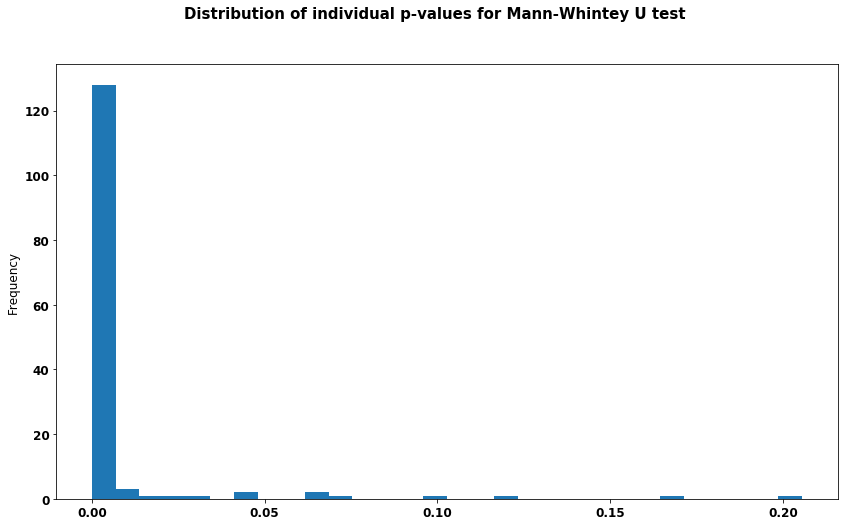

In [24]:
pd.Series([v for v in dic_mannwhitneyu.values()]).plot.hist(bins=30)
plt.suptitle("Distribution of individual p-values for Mann-Whintey U test",
             weight="bold",
            fontsize=15)

Text(0.5, 0.98, 'Distribution of individual p-values for Fisher association test')

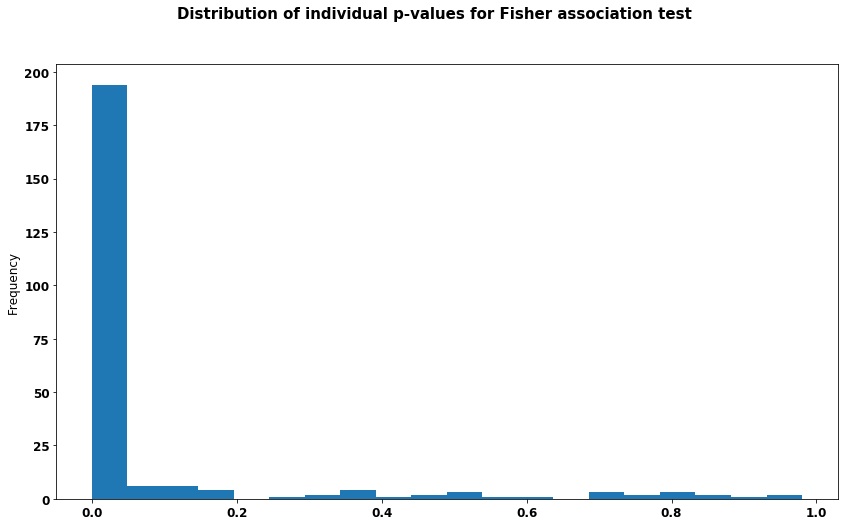

In [25]:
pd.Series([v for v in dic_fisher.values()]).plot.hist(bins=20)
plt.suptitle("Distribution of individual p-values for Fisher association test", 
             size=30,
             weight="bold",
            fontsize=15)

### 5. Multiple hypotheses testing correction: Bonferroni Method

In order to handle the multiple testing problem (increase in the probability to "discover" false statistical associations), we will use the Bonferroni correction method. Although many other multiple comparisons exist, Bonferroni is the most straightforward to use, because it doesn't require assumptions about variables correlation. Other PheWAS analysis also use False Discovery Rate controlling procedures ([see](https://en.wikipedia.org/wiki/False_discovery_rate)).

In a nutshell, Bonferonni allows to calculate a corrected "statistical significant threshold" according to the number of test performed. Every p-value below this threshold will be deemed statistically significant.

In [26]:
%%capture
# Merging pvalues from different tests
dic_pvalues = {**dic_mannwhitneyu, **dic_fisher}
df_pvalues = pd.DataFrame.from_dict(dic_pvalues, orient="index", columns=["pvalues"])\
.rename_axis("dummies_varName")\
.reset_index(drop=False)

# Adding pvalues results as a new column to variablesDict
variablesDict = joining_variablesTable_onCol(variablesDict,
                                              df_pvalues,
                                              left_col="dummies_varName",
                                              right_col="dummies_varName")

adjusted_alpha = 0.05/len(variablesDict["pvalues"])
variablesDict["p_adj"] = variablesDict["pvalues"] / len(variablesDict["pvalues"])
variablesDict['log_p'] = -np.log10(variablesDict['pvalues'])
variablesDict = variablesDict.sort_index()
variablesDict["group"] = variablesDict.reset_index(level=2)["level_2"].values

In [27]:
print("Bonferonni adjusted significance threshold: {0:.2E}".format(adjusted_alpha))

Bonferonni adjusted significance threshold: 1.26E-04


## 6. Result visualisations: Manhattan plot

Manhattan plot is the classical results representation of a PheWAS analysis. It plots every each tested phenotypical variables on the X-axis, against its *-log(pvalue)* on the Y-axis. The horizontal line represent the adjusted significance level threshold.

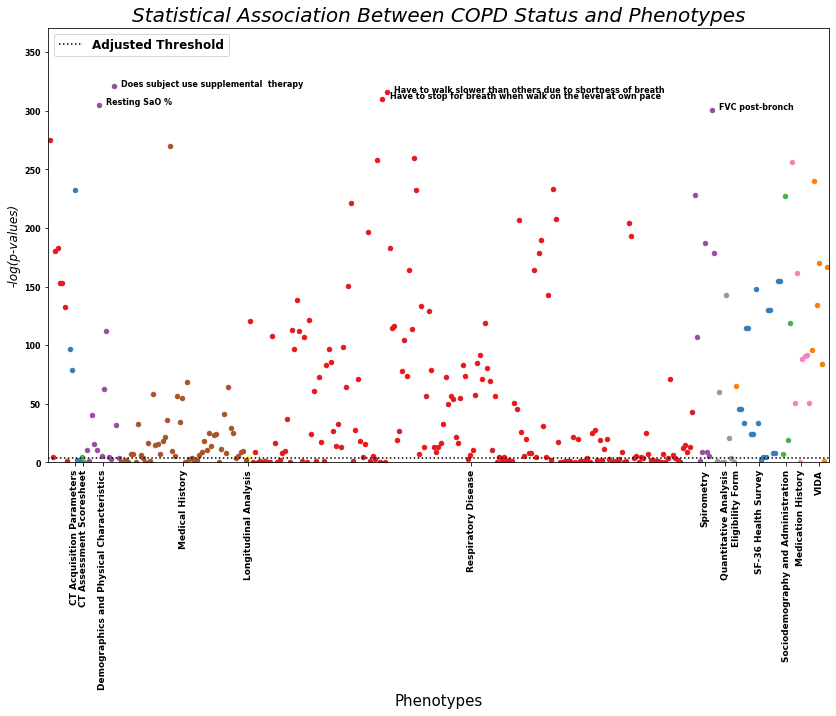

In [28]:
mask = variablesDict["pvalues"].isna()
df_results = variablesDict.loc[~mask,:].copy().replace([np.inf, -np.inf], np.nan)
df_results = df_results.loc[~df_results["log_p"].isna().values,:]

#### Specific adjustment to make this specific plot looks nicer
####### to adapt when changing data or dependent variable
df_results = df_results.replace({"TLC": "Spirometry",
                                 "New Gold Classification": "Quantitative Analysis", 
                  "Other": "Demographics"})
group_order={'6MinWalk': 0,
 'CT Acquisition Parameters': 1,
 'CT Assessment Scoresheet': 2,
 'Demographics and Physical Characteristics': 3,
 'Eligibility Form': 10,
 'Longitudinal Analysis': 5,
 'Medical History': 4,
 'Medication History': 13,
 'Quantitative Analysis': 9,
 'Respiratory Disease': 6,
 'SF-36 Health Survey': 11,
 'Sociodemography and Administration': 12,
 'Spirometry': 7,
 'VIDA': 15}
df_results["group_order"] = df_results["group"].replace(group_order)
df_results = df_results.sort_values("group_order", ascending=True)
df_results["simplified_varName"] = df_results["simplified_varName"].str.replace("[0-9]+[A-z]*", "").to_frame()
###


fig = plt.figure()
ax = fig.add_subplot(111)
colors = plt.get_cmap('Set1')
x_labels = []
x_labels_pos = []

y_lims = (0, df_results["log_p"].max(skipna=True) + 50)
threshold_top_values = df_results["log_p"].sort_values(ascending=False)[0:6][-1]

df_results["ind"] = np.arange(1, len(df_results)+1)
#df_results["group"] = df_results["group"].str.replace("[0-9]", "")
df_grouped = df_results.groupby(('group'))
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='log_p',color=colors.colors[num % len(colors.colors)], ax=ax, s=20)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2)) # Set label in the middle

    pair_ind = 0 # To shift label which might overlap because to close
    for n, row in group.iterrows():
#        if pair_ind %2 == 0:
#            shift = 1.1
#        else:
#            shift = -1.1
        if row["log_p"] > threshold_top_values:
            ax.text(row['ind'] + 3, row["log_p"] + 0.05, row["simplified_varName"], rotation=0, alpha=1, size=8, color="black")
#            pair_ind += 1
                
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df_results) +1])
ax.set_ylim(y_lims)
ax.set_ylabel('-log(p-values)', style="italic")
ax.set_xlabel('Phenotypes', fontsize=15)
ax.axhline(y=-np.log10(adjusted_alpha), linestyle=":", color="black", label="Adjusted Threshold")
plt.xticks(fontsize = 9,rotation=90)
plt.yticks(fontsize = 8)
plt.title("Statistical Association Between COPD Status and Phenotypes", 
          loc="center",
          style="oblique", 
          fontsize = 20,
         y=1)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = labels, loc = "upper left")
plt.show()

Overall, it appears that most of the tested phenotypes covariates are above the adjusted threshold of significant association. However, it is not surprising at all, given the nature of our dependent variable: a lot of those variables are by nature tied directly to the COPD status.

This code can be used directly with any other variable present in the variable Dictionary. It only need to change the `dependent_var_name` value.